# Simple regression problem

In this notebook we train a small neural network on a dataset in the form of a noisy parabola.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.nn import Linear, Module, ReLU, Sequential
from torch.utils.data import DataLoader, Dataset

In [2]:
class ParabolaDataset(Dataset):
    '''The training data is generated from the parabola
              y = x ** 2 
    Random noise in the range `[-0.01, 0.01]` is added
    to the function value `y`.
    '''

    def __init__(self, nsamples):
        self.nsamples = nsamples

        # A dedicated random number generator for the dataset
        self.rnd_gen_data = torch.Generator().manual_seed(1)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(1,).uniform_(-0.5, 0.5, generator=self.rnd_gen_data)
        y = x ** 2
        noise = torch.FloatTensor(1,).uniform_(-0.01, 0.01, generator=self.rnd_gen_data)
        return (x, y + noise)

    def __len__(self):
        return self.nsamples

In [3]:
train_set = ParabolaDataset(
    nsamples = 128
)

train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=False,
    drop_last=True
)

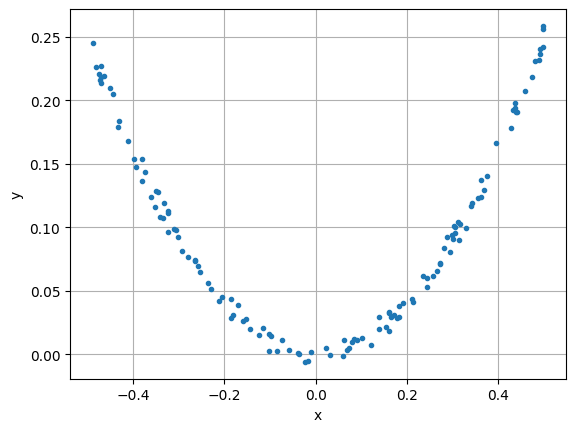

In [4]:
x_plot = []
y_plot = []
for x, y in train_loader:
    x_plot.append(x)
    y_plot.append(y)

x_plot = torch.cat(x_plot)
y_plot = torch.cat(y_plot)

plt.plot(x_plot, y_plot, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Defining the model, a loss function and an optimizer

Uses a two layer model

In [13]:
# inherit from Module
class ReLUNet(Module):
    # needs an initit function
    def __init__(self):
        super().__init__()
        hidden_size = 200
        self.net = Sequential(
            Linear(1, hidden_size),
            ReLU(),
            Linear(hidden_size, hidden_size*2),
            ReLU(),
            Linear(hidden_size*2, 1)
        )
        # The class sequential is used to define the layers
        #first a linear layer taking one input, turn to higher dimension (hidden_size: width = 200)
        #pass a ReLu activation function with max(0,x) with a small weight to avoid near 0
        # pass the hidden_suze to 1 to get the output --> 1:200-->ReLu-->200:1
        # Could be expanded to another hidden layer, by adding another ReLu and adding the new layers again

    def forward(self, x):
        return self.net(x)

In [14]:
# Select a model: 
# Create a linear model with 1 input and 1 output (y = wx + b),
# and move it to the selected device (gpu)
model = ReLUNet()
model = model.to(0)

# Select a loss function
# This is the loss function we want to minimize
loss_fn = torch.nn.MSELoss()

# Select an optimizer
# Uses ADAM (adaptive moment estimation)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Training

In [15]:
def log(loss):
    """Utility function for plotting"""

    return loss.cpu().detach().numpy()

In [16]:
# Training is the same as before
num_epochs = 200
history = []

for epoch in range(num_epochs):                 #   loop over epochs:
    # set a seed at each epoch to always        #
    # generate the same set of random x         #
    train_set.rnd_gen_data.manual_seed(1)       #
    #                                           #
    for x, y in train_loader:                   #      loop over batches:  -> (x, y)
        optimizer.zero_grad()                   #         * reset automatic differentiation record
        y_hat = model(x.to(0))                  #         * evaluate the model in a batch -> y_hat (forward pass)
        loss = loss_fn(y_hat, y.to(0))          #         * evaluate the loss function with the obtained y_hat and y
        history.append(log(loss))               #           [not part of the traing] keep values for plotting later
        loss.backward()                         #         * backpropagation -> gradients
        optimizer.step()                        #         * update weights with the gradients

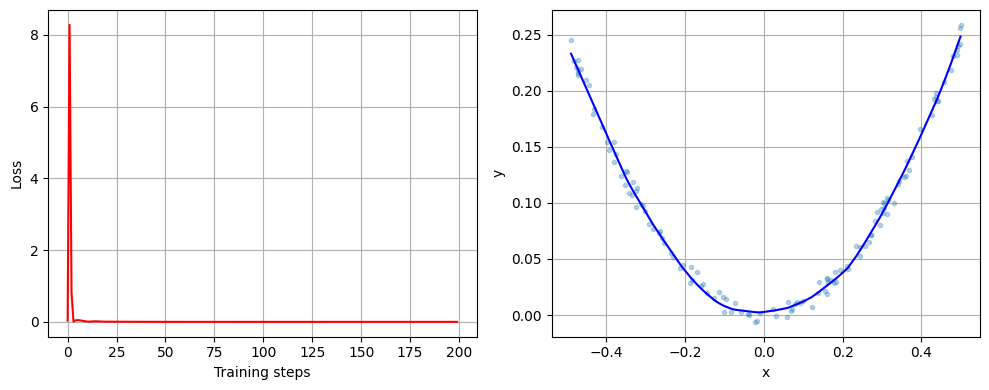

In [17]:
loss_hist  = np.array(history)

matplotlib.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
plt.plot(loss_hist, 'r-')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x_plot, y_plot, '.', alpha=.3)

model.cpu()
with torch.no_grad():
    x_plot_sorted, _ = x_plot.sort(0)
    y_pred = model(x_plot_sorted)

model.to(0)

plt.plot(x_plot_sorted, y_pred.numpy(), 'b-')

plt.xlabel('x')
plt.ylabel('y')
plt.grid()

plt.tight_layout()
plt.show()

matplotlib.rcParams['figure.figsize'] = (6, 4)

### Exercises

 1. Run trainings with different values of the model's parameter `hidden_size` (say, 3, 10, 200) and see how they look ontop of the parabola.
 2. Add a new layer (`Linear` + `ReLU`) to the model

### Discussion

Changing hidden size:

- Reduction of the hidden size increases how rought the data can be represented by the model

Reduction of hidden size to e.g. 3 does not have enough terms to describe the data (sensu taylor expansion, where only using 3 terms results in a very rough description of the observations)

Very wide layers can theoretically fit whatever data you want. However, increasing layers makes computation more expensive.
Thus, increasing the sizes makes the model beeing able to adapt better, but at a computational expense

Adding more layers:
Will likely make the fit better


### Technical check

By this point, you should be comfortable with the following:
 * Writing a model that defines a simple neural network
 * Adding new layers and changing the hidden sizes of the existing ones